In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
%matplotlib notebook
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


Run for RIXS

In [3]:
def load_data(load_name_base, scannum):
    load_name = load_name_base
    
    for jj in range(0, len(scannum)):
        load_name = load_name + '%02d' % scannum[jj] + '_'
    
    eV_on = np.load(load_name + 'eV_on.npy')
    eV_off = np.load(load_name + 'eV_off.npy')
    RIXS_on = np.load(load_name + 'RIXS_on.npy')
    RIXS_off = np.load(load_name + 'RIXS_off.npy')
    Fluo_pump = np.load(load_name + 'Fluo_pump.npy')
    Fluo_unpump = np.load(load_name + 'Fluo_unpump.npy')
    
    return eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump

In [4]:
def plot_rixs_plane(label, axes_range, scannum, eV_on, eV_off, RIXS_on, RIXS_off):

    X,Y = np.meshgrid(np.linspace(0,RIXS_on.shape[1],RIXS_on.shape[1]+1),eV_on)

    plt.figure(figsize=(5,5))
    plt.subplot(3,1,1)
    plt.pcolormesh(X,Y,RIXS_on, vmax = 0.3)
    plt.colorbar()
    plt.xlabel('JF pixel')
    plt.ylabel('Mono Energy (eV)')
    plt.title(label + ', scannum ' + str(scannum) + ' on')
    plt.axis(axes_range)

    X,Y = np.meshgrid(np.linspace(0,RIXS_off.shape[1],RIXS_off.shape[1]+1),eV_off)
    plt.subplot(3,1,2)
    plt.pcolormesh(X,Y,RIXS_off, vmax = 0.3)
    plt.colorbar()
    plt.xlabel('JF pixel')
    plt.ylabel('Mono Energy (eV)')
    plt.title(label + ', scannum ' + str(scannum) + ' off')
    plt.axis(axes_range)

    X,Y = np.meshgrid(np.linspace(0,RIXS_off.shape[1],RIXS_off.shape[1]+1),eV_off)
    plt.subplot(3,1,3)
    plt.pcolormesh(X,Y,RIXS_on - RIXS_off, vmin = -0.1, vmax = 0.1)
    plt.colorbar()
    plt.xlabel('JF pixel')
    plt.ylabel('Mono Energy (eV)')
    plt.title(label + ', scannum ' + str(scannum) + ' on - off')
    plt.axis(axes_range)

    plt.tight_layout()
    

In [5]:
def plot_projected_XAS(label, scannum, eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump):

    plt.figure(figsize=(8,12))
    plt.subplot(4,1,1)
    plt.plot(eV_on, RIXS_on.sum(axis=1), label = "on")
    plt.plot(eV_off, RIXS_off.sum(axis=1), label = 'off')
    plt.xlabel('Mono Energy')
    plt.title(label + ', projected XAS scannum ' + str(scannum))
    plt.legend()

    plt.subplot(4,1,2)
    plt.plot(eV_off, RIXS_on.sum(axis=1)-RIXS_off.sum(axis=1))
    plt.xlabel('Mono Energy')
    plt.title(label + ', projected XAS scannum ' + str(scannum) + ' on - off')

    plt.subplot(4,1,3)
    plt.plot(eV_on, Fluo_pump, label = "on")
    plt.plot(eV_off, Fluo_unpump, label = 'off')
    plt.xlabel('Mono Energy')
    plt.title(label + ', XAS TFY ' + str(scannum))
    plt.legend()

    plt.subplot(4,1,4)
    plt.plot(eV_off, Fluo_pump-Fluo_unpump)
    plt.xlabel('Mono Energy')
    plt.title(label + ', XAS TFY ' + str(scannum) + ' on - off')

    plt.tight_layout()
    

In [6]:
def plot_projected_XES(label, scannum, eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump):
    
    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(RIXS_on.sum(axis=0), label = "on")
    plt.plot(RIXS_off.sum(axis=0), label = "off")
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES scannum ' + str(scannum))
    plt.xlim([130,200])

    plt.subplot(2,1,2)
    plt.plot(RIXS_on.sum(axis=0) - RIXS_off.sum(axis=0))
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES TFY ' + str(scannum) + ' on - off')
    plt.xlim([130,200])

    plt.tight_layout()

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(RIXS_on.sum(axis=0), label = "on")
    plt.plot(RIXS_off.sum(axis=0), label = "off")
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES scannum ' + str(scannum))
    plt.xlim([130,200])

    plt.subplot(2,1,2)
    plt.plot(RIXS_on.sum(axis=0) - RIXS_off.sum(axis=0))
    plt.xlabel('JF pixels')
    plt.title(label + ', projected XES TFY ' + str(scannum) + ' on - off')
    plt.xlim([130,200])

    plt.tight_layout()

In [34]:
def plot_herfd(label, scannum, pixel_min, pixel_max, eV_on, eV_off, RIXS_on, RIXS_off, Fluo_pump, Fluo_unpump):
    
    title_label = label + 'HERFD, (pixels #' + str(pixel_min) + '-' + str(pixel_max) + ')  scannum ' + str(scannum)
    
    plt.figure(figsize=(8,12))
    plt.subplot(4,1,1)
    plt.plot(eV_on, RIXS_on[:,pixel_min:pixel_max].sum(axis=1), label = "on")
    plt.plot(eV_off, RIXS_off[:,pixel_min:pixel_max].sum(axis=1), label = 'off')
    plt.xlabel('Mono Energy')
    plt.title(title_label)
    plt.legend()

    plt.subplot(4,1,2)
    plt.plot(eV_off, RIXS_on[:,pixel_min:pixel_range_max].sum(axis=1) - RIXS_off[:,pixel_min:pixel_max].sum(axis=1))
    plt.xlabel('Mono Energy')
    plt.title(title_label + ', on - off')

    plt.subplot(4,1,3)
    plt.plot(eV_on, Fluo_pump, label = "on")
    plt.plot(eV_off, Fluo_unpump, label = 'off')
    plt.xlabel(label + 'Mono Energy')
    plt.title('XAS TFY ' + str(scannum))
    plt.legend()

    plt.subplot(4,1,4)
    plt.plot(eV_off, Fluo_pump-Fluo_unpump)
    plt.xlabel(label + 'Mono Energy')
    plt.title('XAS TFY ' + str(scannum) + ' on - off')
    
    diff = RIXS_on[:,pixel_min:pixel_range_max].sum(axis=1) - RIXS_off[:,pixel_min:pixel_max].sum(axis=1)
    diff_fluo = Fluo_pump - Fluo_unpump
    
    plt.tight_layout()
    
    return diff, diff_fluo

In [8]:
def plot_cie(peak_label, label, scannum, mono_range_min, mono_range_max, eV_on, eV_off, RIXS_on, RIXS_off):

    title_label = label + ', XES, ' + peak_label + \
        ':' + str(mono_range_min) + '-' + str(mono_range_max) + 'eV, scannum ' + str(scannum)
        
    index_min = min(min(np.where(eV_on < mono_range_max)))
    index_max = max(max(np.where(eV_on > mono_range_min)))

    print('mono_max')
    print(eV_on[index_min])
    print('mono_min')
    print(eV_on[index_max])

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(RIXS_on[index_min:index_max].sum(axis=0), label = "on")
    plt.plot((RIXS_off[index_min:index_max].sum(axis=0)), label = "off")
    #plt.plot(RIXS_off_01[index_min:index_max].sum(axis=0), label = "off")
    plt.xlabel('JF pixels')
    plt.title(title_label)
    plt.xlim([130,200])
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(RIXS_on[index_min:index_max].sum(axis=0) - (RIXS_off[index_min:index_max].sum(axis=0)))
    plt.xlabel('JF pixels')
    plt.title(title_label + ', on - off')
    plt.xlim([130,200])

    plt.tight_layout()

    index_min = min(min(np.where(eV_on < mono_range_max)))
    index_max = max(max(np.where(eV_on > mono_range_min)))

    print('mono_max')
    print(eV_on[index_min])
    print('mono_min')
    print(eV_on[index_max])
    

#     plt.figure(figsize=(8,6))
#     plt.subplot(2,1,1)
#     plt.plot(RIXS_on[index_min:index_max].sum(axis=0), label = "on")
#     plt.plot((RIXS_off[index_min:index_max].sum(axis=0)), label = "off")
#     plt.xlabel('JF pixels')
#     plt.title(label + 'mono XES scannum ' + str(scannum))
#     plt.xlim([130,200])
#     plt.legend()

#     plt.subplot(2,1,2)
#     plt.plot(RIXS_on[index_min:index_max].sum(axis=0) - (RIXS_off[index_min:index_max].sum(axis=0)))
#     plt.xlabel('JF pixels')
#     plt.title(label + 'mono XES scannum ' + str(scannum) + 'on - off')
#     plt.xlim([130,200])

#     plt.tight_layout()

    print(index_min)
    print(index_max)
    
    noise_level = np.std(RIXS_on[index_min:index_max].sum(axis=0) - RIXS_off[index_min:index_max].sum(axis=0),axis=0)
    print(noise_level.shape)
    
    print('Standard deviation of difference is: ' + str(noise_level))

Load data

In [9]:
label_01 = 'RuDimerACN, 0.6 ps, horz, '
scannum_01 = [6, 7, 9]
LBASE_01 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_0p6ps_scans_'
eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01 = load_data(LBASE_01, scannum_01)

label_02 = 'RuDimerACN, 10 ps, horz, '
scannum_02 = [5, 8, 10, 13]
LBASE_02 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_10ps_scans_'
eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02, Fluo_pump_02, Fluo_unpump_02 = load_data(LBASE_02, scannum_02)

label_03 = 'RuDimerACN, 0.6 ps, vert, '
scannum_03 = [10, 11, 12]
#scannum_03 = [10]
LBASE_03 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_0p6ps_scans_'
eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03 = load_data(LBASE_03, scannum_03)

label_04 = 'RuDimerACN, 10 ps, vert, '
scannum_04 = [15, 16, 17, 18]
LBASE_04 = '/das/work/p17/p17983/Reduced_data/RuDimerACN_10ps_scans_'
eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04, Fluo_pump_04, Fluo_unpump_04 = load_data(LBASE_04, scannum_04)


Plot RIXS planes

In [10]:
axes_range = [130, 200, 2831, 2852]

# plot_rixs_plane(label_01, axes_range, scannum_01, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [11]:
# plot_rixs_plane(label_02, axes_range, scannum_02, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

In [12]:
# plot_rixs_plane(label_03, axes_range, scannum_03, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

In [13]:
# plot_rixs_plane(label_04, axes_range, scannum_04, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [14]:
# plot_projected_XAS(\
#        label_01, scannum_01, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01, Fluo_pump_01, Fluo_unpump_01)
# plot_projected_XAS(\
#        label_02, scannum_02, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02, Fluo_pump_02, Fluo_unpump_02)
# plot_projected_XAS(\
#        label_03, scannum_03, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03)

In [15]:
# plot_projected_XES(\
#        label_03, scannum_03, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03)


<IPython.core.display.Javascript object>


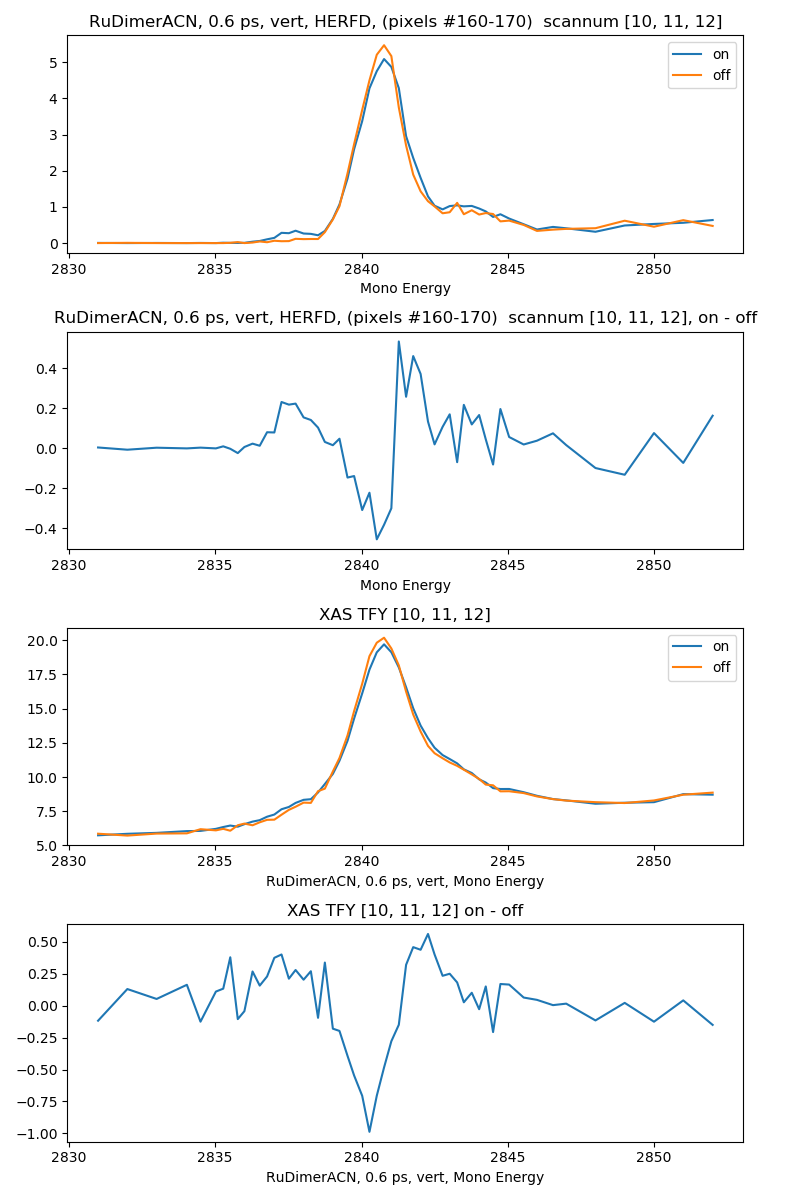

<IPython.core.display.Javascript object>


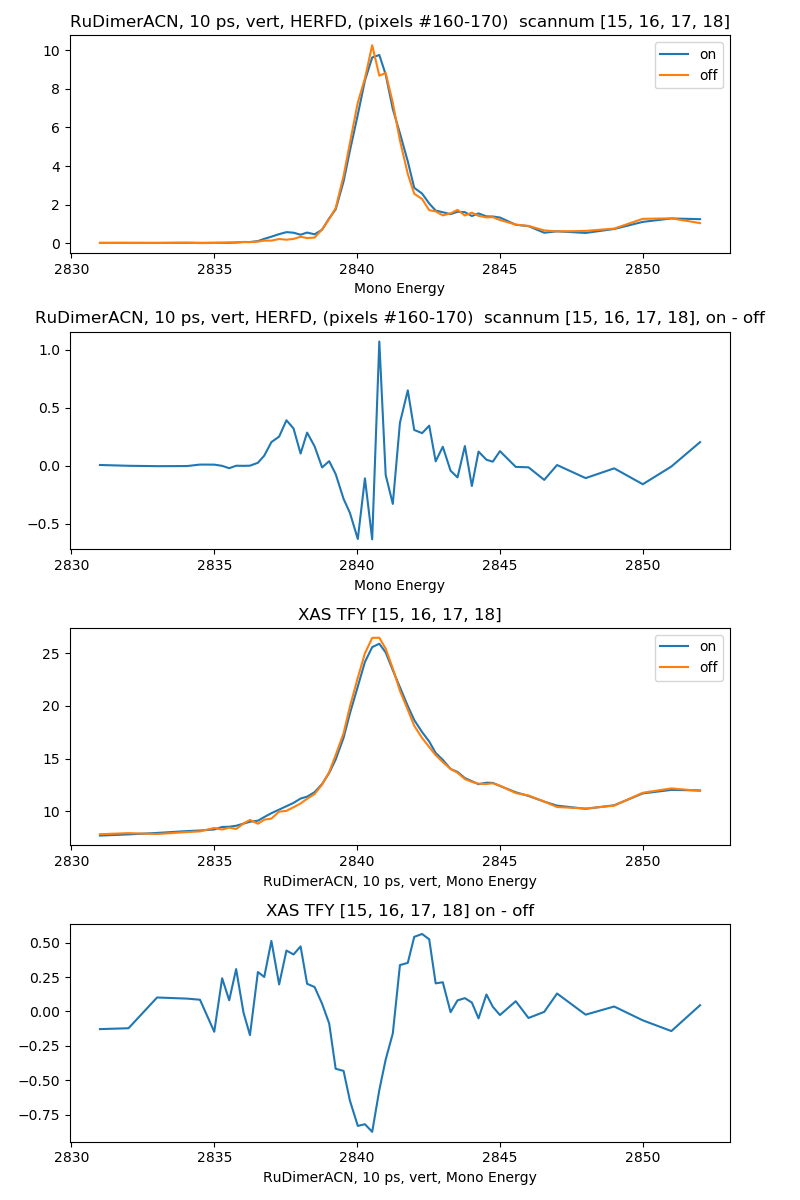

<IPython.core.display.Javascript object>


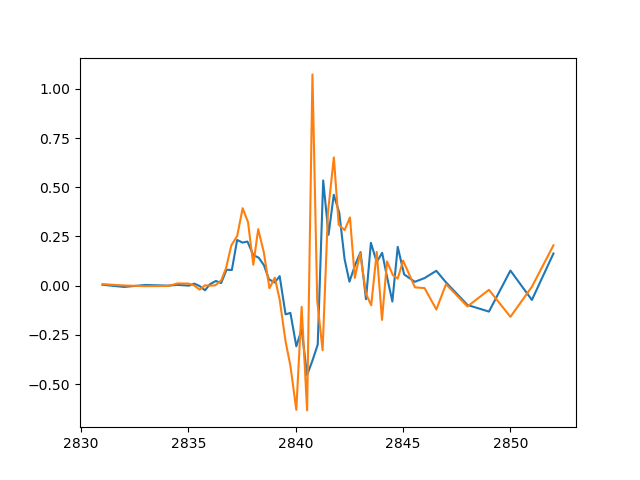

<IPython.core.display.Javascript object>


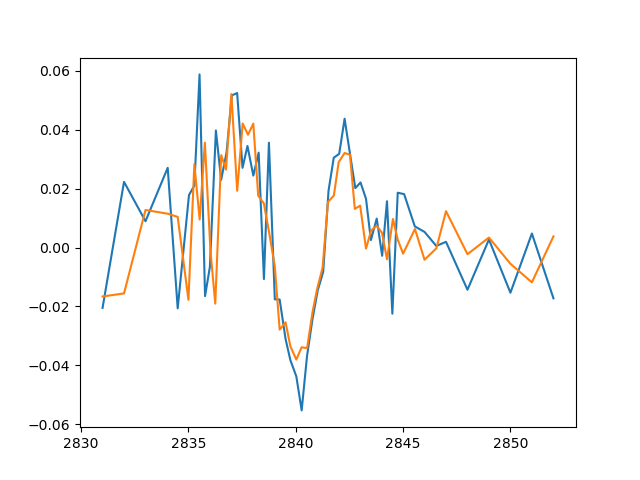

In [36]:
pixel_range_max = 170
pixel_range_min = 160

diff_03, diff_fluo_03 = plot_herfd(label_03, scannum_03, pixel_range_min, pixel_range_max,\
           eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03, Fluo_pump_03, Fluo_unpump_03)

diff_04, diff_fluo_04 = plot_herfd(label_04, scannum_04, pixel_range_min, pixel_range_max,\
           eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04, Fluo_pump_04, Fluo_unpump_04)

plt.figure()
plt.plot(eV_off_03, diff_03)
plt.plot(eV_off_04, diff_04)

plt.figure()
plt.plot(eV_off_03, diff_fluo_03/Fluo_pump_03)
plt.plot(eV_off_04, diff_fluo_04/Fluo_pump_04)

mono_max
2836.772246382502
mono_min
2836.2762005425684


<IPython.core.display.Javascript object>


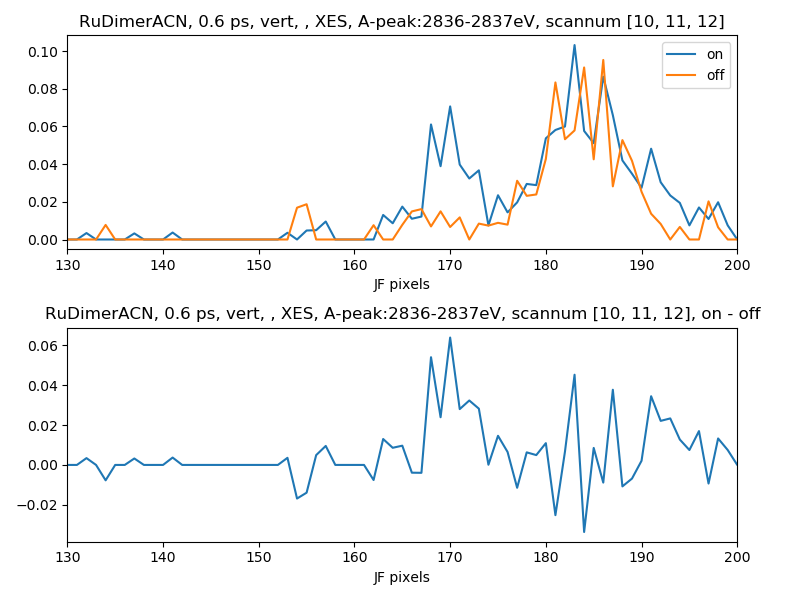

mono_max
2836.772246382502
mono_min
2836.2762005425684
42
44
()
Standard deviation of difference is: 0.00817015124542093
mono_max
2836.9969740846614
mono_min
2836.021063005375


<IPython.core.display.Javascript object>


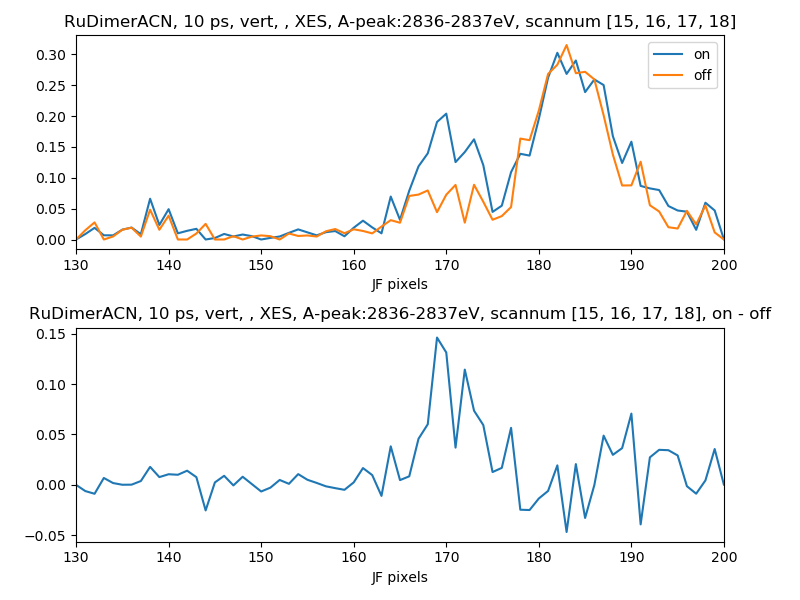

mono_max
2836.9969740846614
mono_min
2836.021063005375
41
45
()
Standard deviation of difference is: 0.017656130927863896


In [17]:
mono_range_min = 2836
mono_range_max = 2837
peak_label = 'A-peak'

plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)
plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [18]:
mono_range_min = 2840
mono_range_max = 2841
peak_label = 'B-peak'

# plot_cie(peak_label, label_01, scannum_01, mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [19]:
# plot_cie(peak_label, label_02, scannum_02, mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

mono_max
2840.770926783911
mono_min
2840.023628382776


<IPython.core.display.Javascript object>


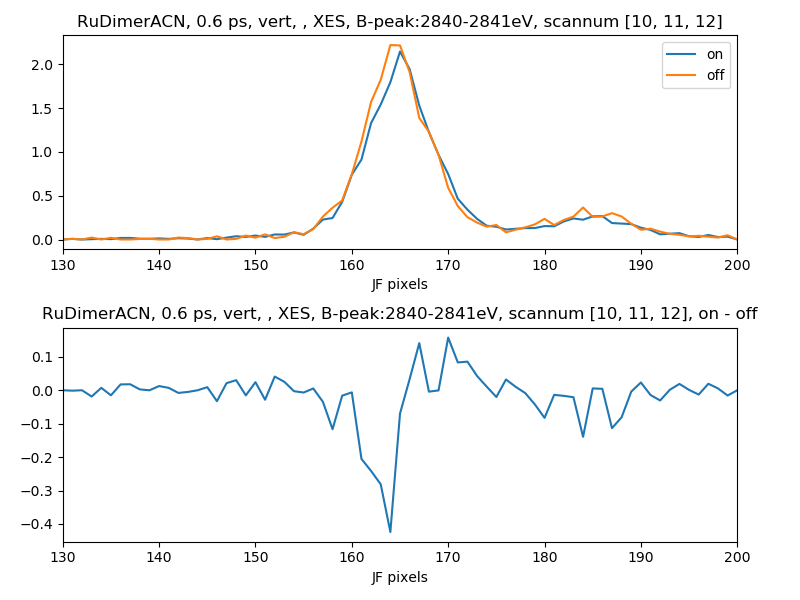

mono_max
2840.770926783911
mono_min
2840.023628382776
26
29
()
Standard deviation of difference is: 0.04071201939115663


In [20]:
plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

mono_max
2840.9974948490512
mono_min
2840.0217549217027


<IPython.core.display.Javascript object>


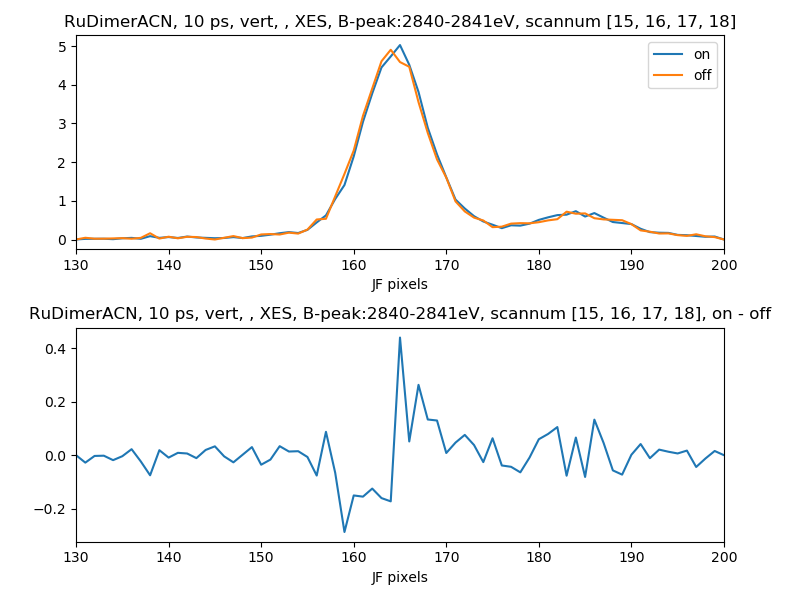

mono_max
2840.9974948490512
mono_min
2840.0217549217027
25
29
()
Standard deviation of difference is: 0.04563525376809573


In [21]:
plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [22]:
mono_range_min = 2841.5
mono_range_max = 2842.5
peak_label = 'C-peak'

# plot_cie(peak_label, label_01, scannum_01, mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [23]:
# plot_cie(peak_label, label_02, scannum_02, mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

mono_max
2842.497247215983
mono_min
2841.5238139064772


<IPython.core.display.Javascript object>


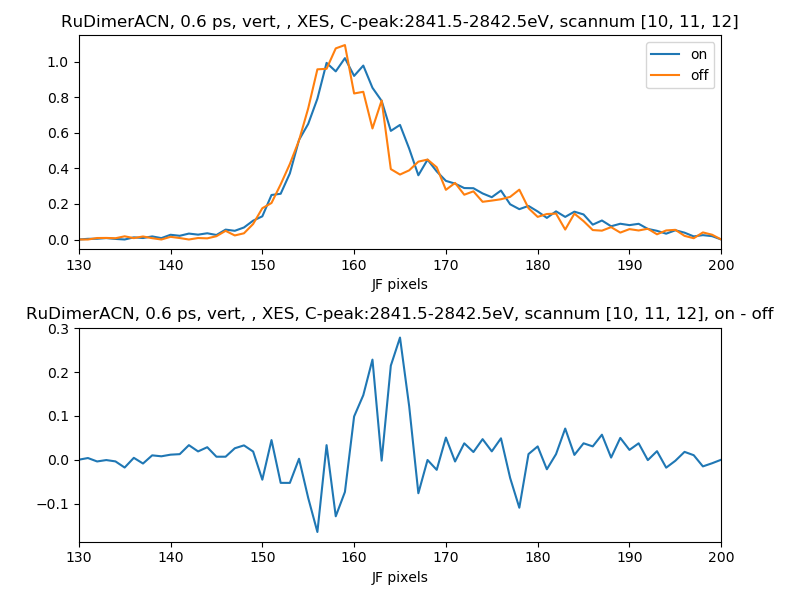

mono_max
2842.497247215983
mono_min
2841.5238139064772
19
23
()
Standard deviation of difference is: 0.0336457452190488


In [24]:
plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

mono_max
2842.272256208947
mono_min
2841.771704245226


<IPython.core.display.Javascript object>


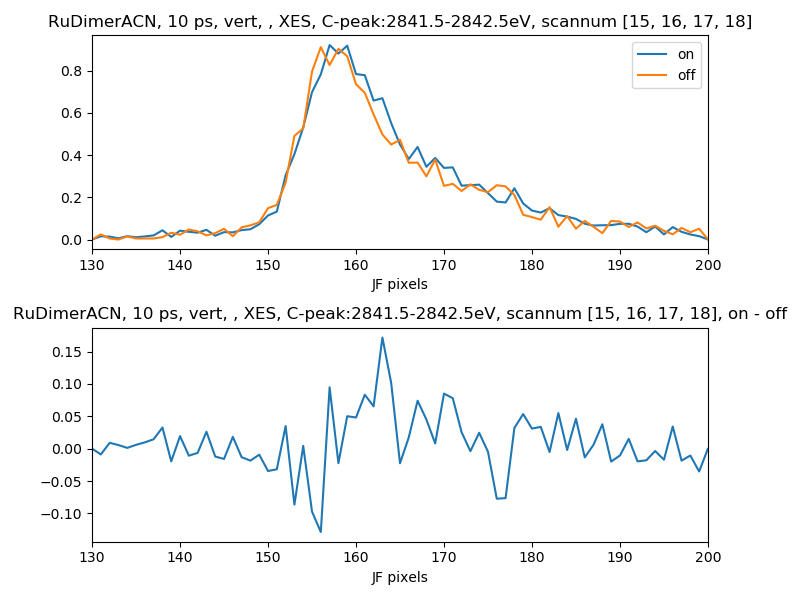

mono_max
2842.272256208947
mono_min
2841.771704245226
20
22
()
Standard deviation of difference is: 0.022930700757739716


In [25]:
plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

mono_max
2843.7686240477474
mono_min
2843.0139894355325


<IPython.core.display.Javascript object>


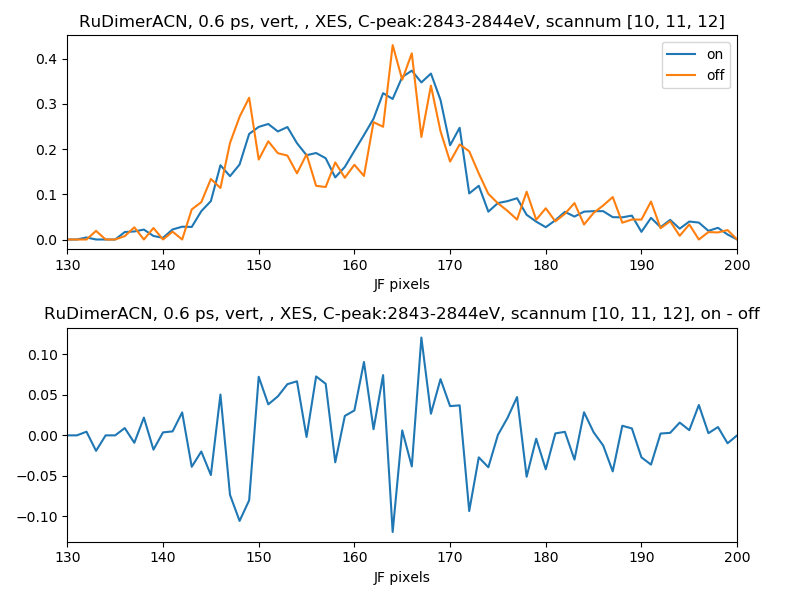

mono_max
2843.7686240477474
mono_min
2843.0139894355325
14
17
()
Standard deviation of difference is: 0.021574484075454706
mono_max
2843.769785562333
mono_min
2843.2694510674455


<IPython.core.display.Javascript object>


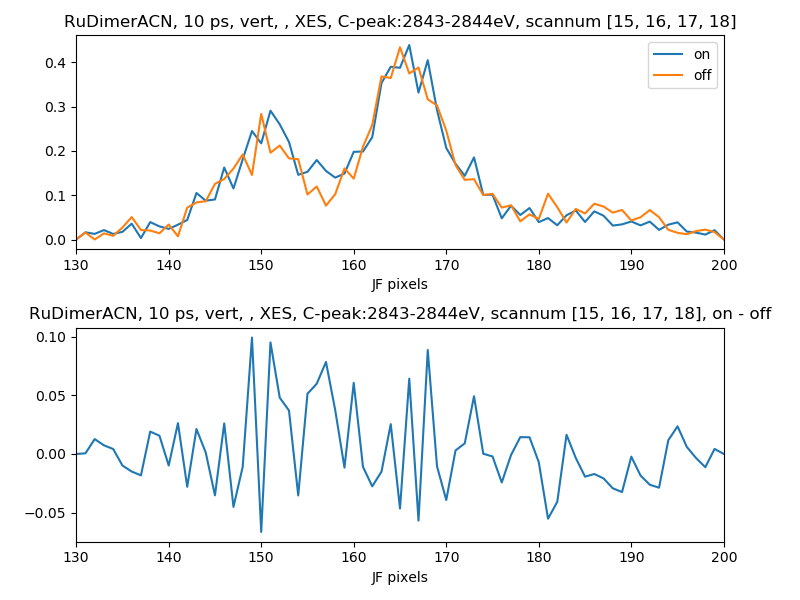

mono_max
2843.769785562333
mono_min
2843.2694510674455
14
16
()
Standard deviation of difference is: 0.017150996397094463


In [26]:
mono_range_min = 2843
mono_range_max = 2844
peak_label = 'C-peak'

plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)
plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [27]:
mono_range_min = 2845
mono_range_max = 2846
peak_label = 'C-peak'

# plot_cie(peak_label, label_01, scannum_01, mono_range_min, mono_range_max, eV_on_01, eV_off_01, RIXS_on_01, RIXS_off_01)

In [28]:
# plot_cie(peak_label, label_02, scannum_02, mono_range_min, mono_range_max, eV_on_02, eV_off_02, RIXS_on_02, RIXS_off_02)

mono_max
2845.996749511683
mono_min
2845.0462750961533


<IPython.core.display.Javascript object>


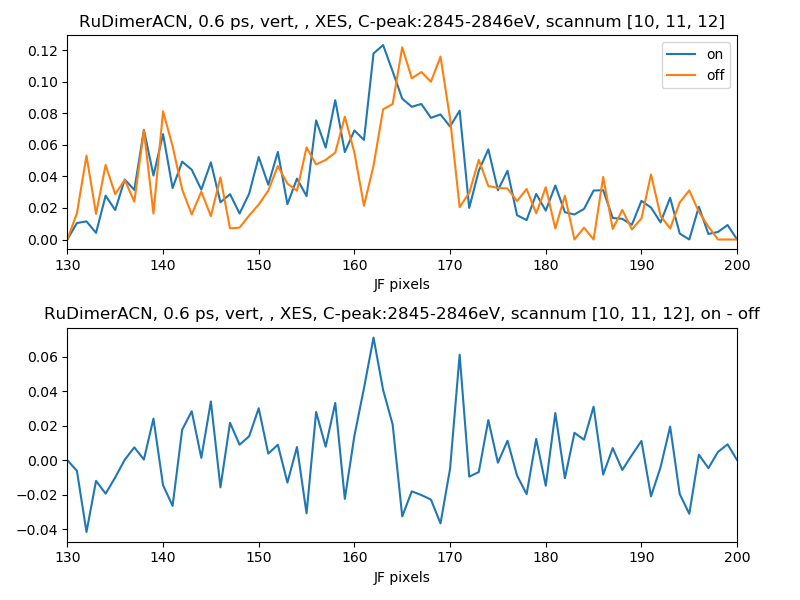

mono_max
2845.996749511683
mono_min
2845.0462750961533
7
9
()
Standard deviation of difference is: 0.010763893485369476


In [29]:
plot_cie(peak_label, label_03, scannum_03, mono_range_min, mono_range_max, eV_on_03, eV_off_03, RIXS_on_03, RIXS_off_03)

mono_max
2845.9966162156875
mono_min
2845.5497955222563


<IPython.core.display.Javascript object>


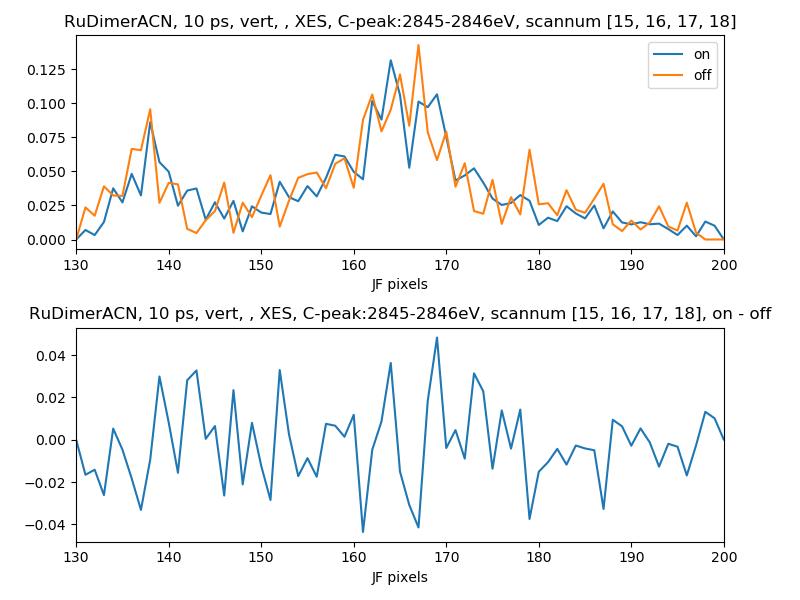

mono_max
2845.9966162156875
mono_min
2845.5497955222563
7
8
()
Standard deviation of difference is: 0.009226915685677463


In [30]:
plot_cie(peak_label, label_04, scannum_04, mono_range_min, mono_range_max, eV_on_04, eV_off_04, RIXS_on_04, RIXS_off_04)

In [31]:



# plt.figure(figsize=(8,3))
# plt.plot((RIXS_on_01[index_min:index_max].sum(axis=0))/3, label = str(scannum_01) + "on")
# plt.plot((RIXS_on_02[index_min:index_max].sum(axis=0))/2, label = str(scannum_02) + "on")
# plt.xlabel('JF pixels')
# plt.title('mono XES scannum')
# plt.xlim([130,200])
# plt.legend()
# plt.tight_layout()

# plt.figure(figsize=(8,3))
# plt.plot((RIXS_off_01[index_min:index_max].sum(axis=0))/3, label = str(scannum_01) + "off")
# plt.plot((RIXS_off_02[index_min:index_max].sum(axis=0))/2, label = str(scannum_02) + "off")
# plt.xlabel('JF pixels')
# plt.title('mono XES scannum')
# plt.xlim([130,200])
# plt.legend()
# plt.tight_layout()


